## Install and Imports

In [ ]:
# (Re-)install Pytorch 2.2.1 (known to work). It might take a few minutes depending on network speed.
!pip uninstall --yes opencv-python opencv-python-headless opencv-contrib-python thinc
!pip uninstall --yes torch torchvision torchaudio torchtext
!pip install torch==2.2.1 torchvision==0.17.1

# Install scienceplot
!pip install scienceplots
!pip install scipy==1.16.0
!pip install torchsummary

# Install the Auto_LiRPA library.
!pip install git+https://github.com/Verified-Intelligence/auto_LiRPA

# Clear installation output to avoid clutter.
from IPython.display import clear_output
# clear_output()

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
   ━━━━━━

In [ ]:
!pip install numpy==1.26.4

In [ ]:
import math
import joblib

import numpy as np
import h5py
import scipy
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import os

from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import PerturbationLpNorm

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from timeit import default_timer
import clust_augmentation as ca

from matplotlib.patches import Rectangle

# import scienceplots
# plt.style.use('science')

import warnings
warnings.filterwarnings("ignore")


## Load Data

In [ ]:
drive_path = 'drive/MyDrive/lirpa_darcy'
PATH = f'{drive_path}/Darcy_Triangular_FNO_int.mat'

In [ ]:
class MatReader(object):
    def __init__(self, file_path, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_float(self, to_float):
        self.to_float = to_float

In [ ]:
def create_data(path, n_train = 1000, n_val=500, n_test=200, rand = 42, ret="interval"):
    assert ret.lower() in ["interval", "midpoint"]

    reader = MatReader(path)

    r = 2
    h = int(((101 - 1)/r) + 1)
    s = h

    x_read_min = np.array(reader.read_field('boundCoeff_min')[:,::r,::r][:,:s,:s])
    x_read_max = np.array(reader.read_field('boundCoeff_max')[:,::r,::r][:,:s,:s])
    y_read_min = np.array(reader.read_field('sol_min')[:,::r,::r][:,:s,:s])
    y_read_max = np.array(reader.read_field('sol_max')[:,::r,::r][:,:s,:s])

    # Training data

    n_total = x_read_min.shape[0]
    n_test_all = n_total - n_train

    idxs = np.arange(x_read_min.shape[0])
    idx_train, idx_test = train_test_split(idxs, test_size=n_test_all/n_total,
                                            random_state=rand)
    idx_val, idx_test = train_test_split(idx_test, train_size=n_val/n_test_all,
                                            random_state=rand)

    x_min = x_read_min[:n_total].reshape((n_total, 1, s, s))  # X input
    x_max = x_read_max[:n_total].reshape((n_total, 1, s, s))  # X input
    y_min = y_read_min[:n_total].reshape((n_total, s, s, 1))  # HF output
    y_max = y_read_max[:n_total].reshape((n_total, s, s, 1))  # HF output

    idx_test = idx_test[:n_test, ...] # Get the actual number "n_test" test data

    u_train_min, g_train_min = x_min[idx_train, ...], y_min[idx_train, ...]
    u_train_max, g_train_max = x_max[idx_train, ...], y_max[idx_train, ...]
    u_val_min, g_val_min = x_min[idx_val, ...], y_min[idx_val, ...]
    u_val_max, g_val_max = x_max[idx_val, ...], y_max[idx_val, ...]
    u_test_min, g_test_min = x_min[idx_test, ...], y_min[idx_test, ...]
    u_test_max, g_test_max = x_max[idx_test, ...], y_max[idx_test, ...]

    # Get mid values for u_train, g_train, u_val, and g_val
    u_train_mid = 0.5 * (u_train_min + u_train_max)
    g_train_mid = 0.5 * (g_train_min + g_train_max)
    u_val_mid = 0.5 * (u_val_min + u_val_max)
    g_val_mid = 0.5 * (g_val_min + g_val_max)

    # x space
    n_train = u_train_min.shape[0]
    n_val = u_val_min.shape[0]
    n_test = u_test_min.shape[0]

    xspace = np.linspace(0,1,51,endpoint=False)
    yspace = xspace.copy()
    gridspace = np.meshgrid(xspace,xspace)
    x_grid = gridspace[0].reshape(51**2,1)
    y_grid = gridspace[1].reshape(51**2,1)

    x1_grid_train = np.tile(x_grid,(u_train_min.shape[0],1,1))
    x2_grid_train = np.tile(y_grid,(u_train_min.shape[0],1,1))
    x1_grid_test = np.tile(x_grid,(n_test,1,1))
    x2_grid_test = np.tile(y_grid,(n_test,1,1))

    space_train = np.concatenate([x2_grid_train,x1_grid_train], axis=-1)
    space_test = np.concatenate([x2_grid_test,x1_grid_test], axis=-1)

    # Stacking min and max
    u_train_int = np.stack([u_train_min, u_train_max], axis=-1)
    g_train_int = np.stack([g_train_min, g_train_max], axis=-1)

    u_test_int = np.stack([u_test_min, u_test_max], axis=-1)
    g_test_int = np.stack([g_test_min, g_test_max], axis=-1)

    u_val_int = np.stack([u_val_min, u_val_max], axis=-1)
    g_val_int = np.stack([g_val_min, g_val_max], axis=-1)

    if ret == "interval":
        return u_train_int, g_train_int, u_val_int, g_val_int, u_test_int, g_test_int, xspace, yspace
    else:
        return u_train_mid, g_train_mid, u_val_int, g_val_int, u_test_int, g_test_int, xspace, yspace

In [ ]:
u_train_mid, g_train_mid, u_val_int, g_val_int, u_test_int, g_test_int, xspace, yspace = create_data(PATH, n_train=1000, n_val=500,
                                                                                                     n_test=200, rand=42, ret="midpoint")

In [ ]:
u_train_mid.shape, g_train_mid.shape, u_test_int.shape, g_test_int.shape, u_val_int.shape, g_val_int.shape

((1000, 1, 51, 51),
 (1000, 51, 51, 1),
 (200, 1, 51, 51, 2),
 (200, 51, 51, 1, 2),
 (500, 1, 51, 51, 2),
 (500, 51, 51, 1, 2))

## Augmentation

In [ ]:
u_train_mid = u_train_mid.reshape(u_train_mid.shape[0], 51**2)
g_train_mid = g_train_mid.reshape(g_train_mid.shape[0], 51**2)
u_aug_train_0, g_aug_train_0, u_clust, g_clust = ca.construct_interval(u_train_mid, g_train_mid, n_clusters=[5,10,20,50,75,100,150,200,300])


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


In [ ]:
u_aug_train = np.expand_dims(u_aug_train_0, axis=1).reshape(u_aug_train_0.shape[0], 1, 51, 51, 2)
g_aug_train = np.expand_dims(g_aug_train_0, axis=2).reshape(u_aug_train_0.shape[0], 51, 51, 1, 2)

In [ ]:
u_aug_train.shape, g_aug_train.shape

((801, 1, 51, 51, 2), (801, 51, 51, 1, 2))

## Formatter

In [ ]:
def data_formatter_nd_interval(u_data, g_data, sensor_coords, nsamp, eval_points=20):
    """
    Extended data formatter that supports upper/lower bounds in the last dimension.

    Parameters:
        u_data: ndarray, shape (nsamp, 1, ..., 2)
        g_data: ndarray, shape (nsamp, ..., 1, 2)
        sensor_coords: list of 1D arrays defining grid coordinates
        nsamp: number of samples to use
        eval_points: number of evaluation points per sample

    Returns:
        branch_tensor: (nsamp * eval_points, n_sensors_total, 2)
        trunk_tensor: (nsamp * eval_points, ndim)
        target_tensor: (nsamp * eval_points, 1, 2)
    """
    ndim = len(sensor_coords)
    sensor_grid = np.stack(np.meshgrid(*sensor_coords, indexing="ij"), axis=-1)  # (*sensor_shape, ndim)
    flat_coords = sensor_grid.reshape(-1, ndim)  # (n_sensors_total, ndim)
    n_sensors_total = flat_coords.shape[0]

    all_branch, all_trunk, all_target = [], [], []

    for i in range(nsamp):
        # Flatten both u and g but keep upper/lower as last dim
        u_i = u_data[i].reshape(-1, 2)  # (n_sensors_total, 2)
        g_i = g_data[i].reshape(-1, 2)  # (n_sensors_total, 2)

        # Random evaluation points
        indices = np.random.choice(n_sensors_total, size=eval_points, replace=False)

        for idx in indices:
            coord = flat_coords[idx]     # (ndim,)
            g_val = g_i[idx]             # (2,) — lower and upper values

            all_branch.append(u_i)       # entire input function with both bounds
            all_trunk.append(coord)
            all_target.append(g_val)     # both lower and upper bounds

    # Stack arrays into tensors
    branch_tensor = np.array(all_branch)   # (nsamp * eval_points, n_sensors_total, 2)
    trunk_tensor = np.array(all_trunk)     # (nsamp * eval_points, ndim)
    target_tensor = np.array(all_target)   # (nsamp * eval_points, 2)

    # Reshape target to (nsamp * eval_points, 1, 2)
    target_tensor = target_tensor.reshape(-1, 1, 2)

    return branch_tensor, trunk_tensor, target_tensor


In [ ]:
u_train, space_train, g_train = data_formatter_nd_interval(u_aug_train, g_aug_train, [xspace,yspace], nsamp=u_aug_train.shape[0], eval_points=200)
u_val, space_val, g_val = data_formatter_nd_interval(u_val_int, g_val_int, [xspace,yspace], nsamp=u_val_int.shape[0], eval_points=200)

In [ ]:
u_train.shape, space_train.shape, g_train.shape

((160200, 2601, 2), (160200, 2), (160200, 1, 2))

In [ ]:
u_val.shape, space_val.shape, g_val.shape

((100000, 2601, 2), (100000, 2), (100000, 1, 2))

## DeepONet Model

In [ ]:
# MLP builder
class MLP(nn.Module):
    def __init__(self, input_dim, output_features, hidden_features, num_hidden_layers):
        super(MLP, self).__init__()
        layers = []

        # Hidden layers
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_features))
            layers.append(nn.LeakyReLU())  # 'leaky_relu' activation
            input_dim = hidden_features

        # Output layer (linear activation)
        layers.append(nn.Linear(hidden_features, output_features))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [ ]:
# DeepONet architecture
class DeepONet(nn.Module):
    def __init__(self, y_in_size, u_in_size, trunk_params, branch_params, out_feat=1):
        """
        Args:
            y_in_size (tuple): e.g., (d_y,)
            u_in_size (tuple): e.g., (d_u,)
            trunk_params (dict): must include 'output_features', 'hidden_features', 'num_hidden_layers'
            branch_params (dict): same as above
            out_feat (int): number of output features
        """
        super(DeepONet, self).__init__()

        d_y = y_in_size[-1]
        d_u = u_in_size[-1]

        self.trunk = MLP(d_y, trunk_params["output_features"],
                         trunk_params["hidden_features"], trunk_params["num_hidden_layers"])

        self.branch = MLP(d_u, branch_params["output_features"],
                          branch_params["hidden_features"], branch_params["num_hidden_layers"])

        self.final = nn.Linear(trunk_params["output_features"], out_feat)

    def forward(self, y_input, u_input):
        # Each input is a batch of shape (batch_size, input_dim)
        trunk_out = self.trunk(y_input)    # (batch_size, output_features)
        branch_out = self.branch(u_input)  # (batch_size, output_features)

        # Elementwise multiply
        mult = trunk_out * branch_out

        # Final output
        return self.final(mult)

In [ ]:
trunk_params=dict()
trunk_params["output_features"] = 128
trunk_params["hidden_features"] = 128
trunk_params["num_hidden_layers"] = 2

branch_params=dict()
branch_params["output_features"] = 128
branch_params["hidden_features"] = 128
branch_params["num_hidden_layers"] = 1

In [ ]:
onet = DeepONet(y_in_size=(2,), u_in_size=(51**2,), trunk_params=trunk_params,
                branch_params=branch_params, out_feat=1)
summary(onet, [(2,), (51**2,)], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
         LeakyReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
         LeakyReLU-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
               MLP-6                  [-1, 128]               0
            Linear-7                  [-1, 128]         333,056
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
              MLP-10                  [-1, 128]               0
           Linear-11                    [-1, 1]             129
Total params: 383,105
Trainable params: 383,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/

In [ ]:
def mse_loss(pred, targets):
    """
    Computes the mse loss between predicted and actual.
    """
    loss = torch.mean(torch.square(pred - targets))

    return loss

In [ ]:
def interval_loss(pred_lo, pred_hi, targets):
    """
    Computes the interval loss between predicted lower and upper bounds.
    """
    term1 = torch.sqrt(F.mse_loss(pred_lo, targets[..., 0]))
    term2 = torch.sqrt(F.mse_loss(pred_hi, targets[..., 1]))
    loss = torch.mean(term1 + term2)

    return loss

In [ ]:
def interval_loss_mid(pred_lo, pred_hi, targets):
    """
    Computes the interval loss between predicted lower and upper bounds.
    """
    mean_targets = torch.mean(targets, dim=-1)
    mean_preds = (pred_lo[...,0] + pred_hi[...,0]) / 2
    mean_width = torch.mean(torch.abs(pred_hi[...,0] - pred_lo[...,0]))
    loss = torch.sqrt(F.mse_loss(mean_preds, mean_targets[...,0])) + 5e-2 * mean_width # mean squared error for the mean of the interval

    return loss

In [ ]:
def train_deeponet(model,
                   train_loader,
                   loss_fun,
                   val_loader=None,
                   epochs=100,
                   optimizer=None,
                   device='cpu',
                   method='CROWN',
                   save_model=False,
                   save_dir='checkpoints',
                   save_best_only=True,
                   verbose=True):

    model.to(device)
    criterion = loss_fun

    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_state_dict = None

    train_losses = []
    val_losses = [] if val_loader is not None else None

    # lr_scheduler = MultiStepLR(optimizer, milestones=[500], gamma=0.5)

    # Wrap LiRPA model
    lirpa_model = BoundedModule(model, (torch.empty((1,2)), torch.empty((1,51**2))), device=device)

    if save_model:
        os.makedirs(save_dir, exist_ok=True)

    # training loop
    for epoch in range(epochs):

        t0 = default_timer()
        model.train()
        train_loss = 0.0

        for y_batch, u_batch, target in train_loader:
            y_batch = y_batch.to(device)
            u_batch = u_batch.to(device)
            target = target.to(device)

            # Convert u inputs to interval
            ub_in = u_batch[..., 1]
            lb_in = u_batch[..., 0]

            center = (lb_in + ub_in) / 2
            eps = (ub_in - lb_in) / 2

            # Define perturbation with per-feature epsilon
            perturbation = PerturbationLpNorm(norm=float("inf"), eps=eps)

            # Wrap input as a bounded tensor
            u_bounded = BoundedTensor(center, perturbation)

            optimizer.zero_grad()
            lb_pred,ub_pred = lirpa_model.compute_bounds(x=(y_batch, u_bounded), method=method)

            loss = criterion(lb_pred, ub_pred, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y_batch.size(0)

        # lr_scheduler.step()
        train_loss /= len(train_loader.dataset)
        t1 = default_timer() - t0
        train_losses.append(train_loss)

        log_msg = f"[Epoch {epoch+1}/{epochs}] Train RMSE: {train_loss:.4f} | Time: {t1:.4f}s"

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for y_val, u_val, target_val in val_loader:
                    y_val = y_val.to(device)
                    u_val = u_val.to(device)
                    target_val = target_val.to(device)

                    # Convert u inputs to interval
                    ub_val = u_val[..., 1]
                    lb_val = u_val[..., 0]

                    center_val = (lb_val + ub_val) / 2
                    eps_val = (ub_val - lb_val) / 2

                    # Define perturbation with per-feature epsilon
                    perturbation_val = PerturbationLpNorm(norm=float("inf"), eps=eps_val)

                    # Wrap input as a bounded tensor
                    u_bounded_val = BoundedTensor(center_val, perturbation_val)

                    lb_pred_val, ub_pred_val = lirpa_model.compute_bounds(x=(y_val, u_bounded_val), method=method)
                    loss = criterion(lb_pred_val, ub_pred_val, target_val)
                    val_loss += loss.item() * y_val.size(0)

            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

            log_msg += f" | Val RMSE: {val_loss:.4f}"

            # Track best model (by val_loss)
            if epoch > 50 and val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state_dict = model.state_dict()
                print(f"Best model updated at epoch {epoch+1} with loss {best_val_loss:.4f}")

        else:
             # No validation set: use train_loss as criterion
            if epoch > 50 and train_loss < best_train_loss:
                best_train_loss = train_loss
                best_state_dict = model.state_dict()
                print(f"Best model updated at epoch {epoch+1} with loss {best_train_loss:.4f}")

        if verbose:
            print(log_msg)

    # Reload best weights before returning
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

        # Save only once at the end
        if save_model:
            fname = "best_model.pt" if save_best_only else "last_model.pt"
            model_path = os.path.join(save_dir, fname)
            torch.save(best_state_dict, model_path)
            print(f"Best model saved to {model_path}")

    return lirpa_model, train_losses, val_losses

# Check Loss Fun Dim

In [ ]:
def run_experiments(trunk_params, branch_params, bound="CROWN", n_train=750, repetitions=5, epochs=100, batch= 1024, verbose=0):

    drive_path = 'drive/MyDrive/lirpa_darcy'
    PATH = f'{drive_path}/Darcy_Triangular_FNO_int.mat'

    n_val = 200
    n_test = 200

    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using {dev} device")
    results = []
    for seed in tqdm(range(repetitions)):
        print(f"Experiment {seed+1}/{repetitions}")
        # Get data
        u_train_mid, g_train_mid, u_val_int, g_val_int, u_test_int, g_test_int, xspace, yspace = create_data(PATH, n_train=1000, n_val=n_val,
                                                                                                             n_test=n_test, rand=42, ret="midpoint")
        # Augment data
        u_train_mid = u_train_mid.reshape(u_train_mid.shape[0], 51**2)
        g_train_mid = g_train_mid.reshape(g_train_mid.shape[0], 51**2)
        u_aug_train_0, g_aug_train_0, u_clust, g_clust = ca.construct_interval(u_train_mid, g_train_mid, n_clusters=[5,10,20,50,75,100,150,200,300])

        u_aug_train = np.expand_dims(u_aug_train_0, axis=1).reshape(u_aug_train_0.shape[0], 1, 51, 51, 2)
        g_aug_train = np.expand_dims(g_aug_train_0, axis=2).reshape(u_aug_train_0.shape[0], 51, 51, 1, 2)
        # get random index with random seed
        np.random.seed(seed)
        idx = np.random.choice(u_aug_train.shape[0], size=n_train, replace=False)
        u_train_int = u_aug_train[idx,...]
        g_train_int = g_aug_train[idx,...]

        # Transform data shape
        u_train, space_train, g_train = data_formatter_nd_interval(u_train_int, g_train_int, [xspace,yspace], nsamp=u_train_int.shape[0], eval_points=200)
        u_val, space_val, g_val = data_formatter_nd_interval(u_val_int, g_val_int, [xspace,yspace], nsamp=u_val_int.shape[0], eval_points=100)

        # Define model
        model = DeepONet(y_in_size=(2,), u_in_size=(51**2,), trunk_params=trunk_params,
                        branch_params=branch_params, out_feat=1)

        # Set optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        res = dict()

        # Create data loader
        train_dataset = TensorDataset(torch.tensor(space_train, dtype=torch.float32),
                              torch.tensor(u_train, dtype=torch.float32),
                              torch.tensor(g_train, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

        val_dataset = TensorDataset(torch.tensor(space_val, dtype=torch.float32),
                                    torch.tensor(u_val, dtype=torch.float32),
                                    torch.tensor(g_val, dtype=torch.float32))
        val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

        # Train model
        model, train_losses, val_losses = train_deeponet(model,
                                                    train_loader,
                                                    loss_fun=interval_loss_mid,
                                                    val_loader=val_loader,
                                                    optimizer=optimizer,
                                                    epochs=epochs,
                                                    device=dev,
                                                    method=bound,
                                                    save_model=True,
                                                    save_dir='ideal_crown/',
                                                    save_best_only=True,
                                                    verbose=verbose)

        ### Evaluate on test set ###
        # Make grid
        gridspace = np.meshgrid(xspace,xspace)
        x_grid = gridspace[0].reshape(51**2)
        y_grid = gridspace[1].reshape(51**2)
        sensor_data = torch.Tensor(np.stack([x_grid,y_grid],axis=0).T).to('cuda')

        lb_pred_list = []
        ub_pred_list = []
        u_test_flat = u_test_int.reshape(n_test, 51**2, 2)
        model.eval()
        for i in range(n_test):
            u_test_lo = u_test_flat[...,0]
            u_test_up = u_test_flat[...,1]
            u_lo = torch.Tensor(u_test_lo[i][None,:].repeat(2601,0)).to('cuda')
            u_up = torch.Tensor(u_test_up[i][None,:].repeat(2601,0)).to('cuda')

            center_test = (u_lo + u_up) / 2
            eps_test = (u_up - u_lo) / 2

            # Define perturbation with per-feature epsilon
            perturbation_test = PerturbationLpNorm(norm=float("inf"), eps=eps_test)

            # Wrap input as a bounded tensor
            u_bounded_test = BoundedTensor(center_test, perturbation_test)

            lb_pred_test, ub_pred_test = model.compute_bounds(x=(sensor_data, u_bounded_test), method=bound)
            lb_pred_list.append(lb_pred_test.detach().cpu().numpy())
            ub_pred_list.append(ub_pred_test.detach().cpu().numpy())

        lb_pred = np.concatenate(lb_pred_list, axis=0).reshape(n_test,51,51).swapaxes(1, 2)
        ub_pred = np.concatenate(ub_pred_list, axis=0).reshape(n_test,51,51).swapaxes(1, 2)

        res["u_train"] = u_train_int
        res["y_train"] = xspace
        res["g_train"] = g_train_int
        res["u_test"] = u_test_int
        res["y_test"] = sensor_data.detach().cpu().numpy()
        res["g_test"] = g_test_int
        res["lb_pred"] = lb_pred
        res["ub_pred"] = ub_pred
        res["train_losses"] = train_losses
        res["val_losses"] = val_losses

        results.append(res)

    return results, model


In [23]:
for nt in [150,250,500,750]:
    print(f"### PROCESSING N_TRAIN {nt} ###")
    results, trained_model = run_experiments(trunk_params, branch_params, bound="IBP",
                            n_train=nt, repetitions=10, epochs=150, batch= 1024, verbose=0)
    joblib.dump(results, f"{drive_path}/deeponet2d_meanaug_ibp_ntrain{nt}.pkl")

### PROCESSING N_TRAIN 150 ###
Using cuda device


  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1/10



100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


Best model updated at epoch 52 with loss 0.1019
Best model updated at epoch 56 with loss 0.1000
Best model updated at epoch 60 with loss 0.0977
Best model updated at epoch 67 with loss 0.0967
Best model updated at epoch 69 with loss 0.0954
Best model updated at epoch 76 with loss 0.0936
Best model updated at epoch 78 with loss 0.0932
Best model updated at epoch 79 with loss 0.0905
Best model updated at epoch 93 with loss 0.0899
Best model updated at epoch 97 with loss 0.0878
Best model updated at epoch 101 with loss 0.0867
Best model updated at epoch 102 with loss 0.0860
Best model updated at epoch 108 with loss 0.0847
Best model updated at epoch 113 with loss 0.0825
Best model updated at epoch 121 with loss 0.0805
Best model updated at epoch 128 with loss 0.0794
Best model updated at epoch 134 with loss 0.0774
Best model updated at epoch 136 with loss 0.0757
Best model updated at epoch 145 with loss 0.0751
Best model updated at epoch 147 with loss 0.0745
Best model saved to ideal_crow

 10%|█         | 1/10 [03:21<30:16, 201.79s/it]

Experiment 2/10



100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


Best model updated at epoch 52 with loss 0.1104
Best model updated at epoch 53 with loss 0.1025
Best model updated at epoch 56 with loss 0.1015
Best model updated at epoch 57 with loss 0.0982
Best model updated at epoch 58 with loss 0.0968
Best model updated at epoch 59 with loss 0.0949
Best model updated at epoch 68 with loss 0.0942
Best model updated at epoch 71 with loss 0.0922
Best model updated at epoch 75 with loss 0.0897
Best model updated at epoch 81 with loss 0.0889
Best model updated at epoch 88 with loss 0.0867
Best model updated at epoch 99 with loss 0.0849
Best model updated at epoch 107 with loss 0.0842
Best model updated at epoch 112 with loss 0.0818
Best model updated at epoch 113 with loss 0.0810
Best model updated at epoch 119 with loss 0.0800
Best model updated at epoch 122 with loss 0.0796
Best model updated at epoch 125 with loss 0.0789
Best model updated at epoch 133 with loss 0.0789
Best model updated at epoch 139 with loss 0.0782
Best model updated at epoch 141 

 20%|██        | 2/10 [06:36<26:21, 197.67s/it]

Experiment 3/10



100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Best model updated at epoch 52 with loss 0.0942
Best model updated at epoch 53 with loss 0.0881
Best model updated at epoch 61 with loss 0.0875
Best model updated at epoch 63 with loss 0.0858
Best model updated at epoch 64 with loss 0.0854
Best model updated at epoch 73 with loss 0.0848
Best model updated at epoch 75 with loss 0.0812
Best model updated at epoch 83 with loss 0.0797
Best model updated at epoch 86 with loss 0.0785
Best model updated at epoch 91 with loss 0.0776
Best model updated at epoch 94 with loss 0.0764
Best model updated at epoch 100 with loss 0.0761
Best model updated at epoch 101 with loss 0.0756
Best model updated at epoch 110 with loss 0.0736
Best model updated at epoch 119 with loss 0.0736
Best model updated at epoch 120 with loss 0.0732
Best model updated at epoch 121 with loss 0.0721
Best model updated at epoch 126 with loss 0.0710
Best model updated at epoch 131 with loss 0.0698
Best model updated at epoch 140 with loss 0.0691
Best model updated at epoch 142

 30%|███       | 3/10 [09:52<22:58, 196.90s/it]

Experiment 4/10



100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Best model updated at epoch 52 with loss 0.0918
Best model updated at epoch 53 with loss 0.0886
Best model updated at epoch 55 with loss 0.0886
Best model updated at epoch 57 with loss 0.0883
Best model updated at epoch 63 with loss 0.0860
Best model updated at epoch 66 with loss 0.0847
Best model updated at epoch 67 with loss 0.0840
Best model updated at epoch 69 with loss 0.0823
Best model updated at epoch 72 with loss 0.0820
Best model updated at epoch 75 with loss 0.0812
Best model updated at epoch 77 with loss 0.0807
Best model updated at epoch 82 with loss 0.0792
Best model updated at epoch 86 with loss 0.0777
Best model updated at epoch 90 with loss 0.0763
Best model updated at epoch 100 with loss 0.0759
Best model updated at epoch 111 with loss 0.0751
Best model updated at epoch 117 with loss 0.0735
Best model updated at epoch 119 with loss 0.0724
Best model updated at epoch 127 with loss 0.0710
Best model updated at epoch 135 with loss 0.0691
Best model updated at epoch 144 wi

 40%|████      | 4/10 [12:59<19:17, 192.94s/it]

Experiment 5/10



100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Best model updated at epoch 52 with loss 0.1072
Best model updated at epoch 53 with loss 0.1068
Best model updated at epoch 57 with loss 0.0999
Best model updated at epoch 64 with loss 0.0970
Best model updated at epoch 66 with loss 0.0961
Best model updated at epoch 72 with loss 0.0948
Best model updated at epoch 77 with loss 0.0933
Best model updated at epoch 81 with loss 0.0929
Best model updated at epoch 83 with loss 0.0894
Best model updated at epoch 89 with loss 0.0880
Best model updated at epoch 103 with loss 0.0844
Best model updated at epoch 106 with loss 0.0843
Best model updated at epoch 108 with loss 0.0834
Best model updated at epoch 109 with loss 0.0823
Best model updated at epoch 122 with loss 0.0803
Best model updated at epoch 123 with loss 0.0803
Best model updated at epoch 124 with loss 0.0799
Best model updated at epoch 128 with loss 0.0796
Best model updated at epoch 129 with loss 0.0781
Best model updated at epoch 143 with loss 0.0767
Best model saved to ideal_crow

 50%|█████     | 5/10 [16:17<16:14, 194.82s/it]

Experiment 6/10



100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Best model updated at epoch 52 with loss 0.0980
Best model updated at epoch 54 with loss 0.0908
Best model updated at epoch 55 with loss 0.0893
Best model updated at epoch 65 with loss 0.0887
Best model updated at epoch 66 with loss 0.0861
Best model updated at epoch 76 with loss 0.0835
Best model updated at epoch 78 with loss 0.0817
Best model updated at epoch 82 with loss 0.0806
Best model updated at epoch 84 with loss 0.0803
Best model updated at epoch 90 with loss 0.0799
Best model updated at epoch 97 with loss 0.0787
Best model updated at epoch 98 with loss 0.0774
Best model updated at epoch 102 with loss 0.0769
Best model updated at epoch 118 with loss 0.0766
Best model updated at epoch 119 with loss 0.0758
Best model updated at epoch 120 with loss 0.0746
Best model updated at epoch 134 with loss 0.0745
Best model updated at epoch 139 with loss 0.0730
Best model updated at epoch 143 with loss 0.0721
Best model updated at epoch 148 with loss 0.0720
Best model saved to ideal_crown/

 60%|██████    | 6/10 [19:26<12:50, 192.74s/it]

Experiment 7/10



100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


Best model updated at epoch 52 with loss 0.0952
Best model updated at epoch 53 with loss 0.0936
Best model updated at epoch 54 with loss 0.0916
Best model updated at epoch 55 with loss 0.0904
Best model updated at epoch 58 with loss 0.0894
Best model updated at epoch 62 with loss 0.0873
Best model updated at epoch 66 with loss 0.0861
Best model updated at epoch 69 with loss 0.0842
Best model updated at epoch 72 with loss 0.0829
Best model updated at epoch 75 with loss 0.0812
Best model updated at epoch 77 with loss 0.0802
Best model updated at epoch 90 with loss 0.0762
Best model updated at epoch 102 with loss 0.0758
Best model updated at epoch 104 with loss 0.0757
Best model updated at epoch 106 with loss 0.0738
Best model updated at epoch 118 with loss 0.0718
Best model updated at epoch 129 with loss 0.0710
Best model updated at epoch 136 with loss 0.0703
Best model updated at epoch 146 with loss 0.0699
Best model updated at epoch 147 with loss 0.0689
Best model saved to ideal_crown/

 70%|███████   | 7/10 [22:33<09:32, 190.86s/it]

Experiment 8/10



100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Best model updated at epoch 52 with loss 0.0959
Best model updated at epoch 53 with loss 0.0953
Best model updated at epoch 57 with loss 0.0946
Best model updated at epoch 59 with loss 0.0932
Best model updated at epoch 60 with loss 0.0926
Best model updated at epoch 61 with loss 0.0912
Best model updated at epoch 65 with loss 0.0903
Best model updated at epoch 70 with loss 0.0880
Best model updated at epoch 73 with loss 0.0860
Best model updated at epoch 78 with loss 0.0856
Best model updated at epoch 79 with loss 0.0838
Best model updated at epoch 80 with loss 0.0830
Best model updated at epoch 82 with loss 0.0827
Best model updated at epoch 83 with loss 0.0825
Best model updated at epoch 86 with loss 0.0800
Best model updated at epoch 90 with loss 0.0785
Best model updated at epoch 96 with loss 0.0778
Best model updated at epoch 98 with loss 0.0765
Best model updated at epoch 108 with loss 0.0764
Best model updated at epoch 110 with loss 0.0741
Best model updated at epoch 112 with l

 80%|████████  | 8/10 [25:48<06:24, 192.19s/it]

Experiment 9/10



100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Best model updated at epoch 52 with loss 0.0895
Best model updated at epoch 55 with loss 0.0888
Best model updated at epoch 58 with loss 0.0838
Best model updated at epoch 60 with loss 0.0835
Best model updated at epoch 65 with loss 0.0826
Best model updated at epoch 66 with loss 0.0806
Best model updated at epoch 69 with loss 0.0806
Best model updated at epoch 71 with loss 0.0799
Best model updated at epoch 76 with loss 0.0798
Best model updated at epoch 78 with loss 0.0789
Best model updated at epoch 79 with loss 0.0765
Best model updated at epoch 90 with loss 0.0754
Best model updated at epoch 95 with loss 0.0747
Best model updated at epoch 98 with loss 0.0739
Best model updated at epoch 100 with loss 0.0737
Best model updated at epoch 101 with loss 0.0731
Best model updated at epoch 110 with loss 0.0718
Best model updated at epoch 120 with loss 0.0716
Best model updated at epoch 122 with loss 0.0712
Best model updated at epoch 123 with loss 0.0705
Best model updated at epoch 124 wi

 90%|█████████ | 9/10 [29:02<03:12, 192.90s/it]

Experiment 10/10



100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


Best model updated at epoch 52 with loss 0.0985
Best model updated at epoch 54 with loss 0.0968
Best model updated at epoch 55 with loss 0.0904
Best model updated at epoch 62 with loss 0.0885
Best model updated at epoch 65 with loss 0.0866
Best model updated at epoch 68 with loss 0.0853
Best model updated at epoch 69 with loss 0.0833
Best model updated at epoch 71 with loss 0.0818
Best model updated at epoch 74 with loss 0.0798
Best model updated at epoch 78 with loss 0.0784
Best model updated at epoch 90 with loss 0.0750
Best model updated at epoch 93 with loss 0.0744
Best model updated at epoch 100 with loss 0.0734
Best model updated at epoch 102 with loss 0.0730
Best model updated at epoch 108 with loss 0.0729
Best model updated at epoch 111 with loss 0.0708
Best model updated at epoch 121 with loss 0.0701
Best model updated at epoch 124 with loss 0.0699
Best model updated at epoch 128 with loss 0.0680
Best model updated at epoch 138 with loss 0.0679
Best model updated at epoch 140 

100%|██████████| 10/10 [32:13<00:00, 193.34s/it]


### PROCESSING N_TRAIN 250 ###
Using cuda device


  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1/10



100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Best model updated at epoch 52 with loss 0.0808
Best model updated at epoch 53 with loss 0.0801
Best model updated at epoch 57 with loss 0.0768
Best model updated at epoch 66 with loss 0.0746
Best model updated at epoch 70 with loss 0.0732
Best model updated at epoch 78 with loss 0.0726
Best model updated at epoch 79 with loss 0.0725
Best model updated at epoch 81 with loss 0.0715
Best model updated at epoch 85 with loss 0.0710
Best model updated at epoch 86 with loss 0.0710
Best model updated at epoch 88 with loss 0.0693
Best model updated at epoch 95 with loss 0.0686
Best model updated at epoch 97 with loss 0.0659
Best model updated at epoch 108 with loss 0.0648
Best model updated at epoch 109 with loss 0.0648
Best model updated at epoch 111 with loss 0.0647
Best model updated at epoch 121 with loss 0.0628
Best model updated at epoch 124 with loss 0.0625
Best model updated at epoch 131 with loss 0.0617
Best model updated at epoch 135 with loss 0.0587
Best model saved to ideal_crown/b

 10%|█         | 1/10 [04:28<40:16, 268.50s/it]

Experiment 2/10



100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


Best model updated at epoch 52 with loss 0.0881
Best model updated at epoch 54 with loss 0.0839
Best model updated at epoch 67 with loss 0.0802
Best model updated at epoch 74 with loss 0.0798
Best model updated at epoch 75 with loss 0.0796
Best model updated at epoch 84 with loss 0.0786
Best model updated at epoch 87 with loss 0.0776
Best model updated at epoch 99 with loss 0.0772
Best model updated at epoch 100 with loss 0.0753
Best model updated at epoch 106 with loss 0.0745
Best model updated at epoch 112 with loss 0.0745
Best model updated at epoch 118 with loss 0.0730
Best model updated at epoch 122 with loss 0.0726
Best model updated at epoch 126 with loss 0.0720
Best model updated at epoch 127 with loss 0.0710
Best model updated at epoch 139 with loss 0.0707
Best model updated at epoch 140 with loss 0.0705
Best model updated at epoch 148 with loss 0.0688
Best model saved to ideal_crown/best_model.pt


 20%|██        | 2/10 [08:56<35:45, 268.16s/it]

Experiment 3/10



100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Best model updated at epoch 52 with loss 0.0770
Best model updated at epoch 57 with loss 0.0759
Best model updated at epoch 63 with loss 0.0748
Best model updated at epoch 67 with loss 0.0739
Best model updated at epoch 71 with loss 0.0737
Best model updated at epoch 73 with loss 0.0729
Best model updated at epoch 76 with loss 0.0715
Best model updated at epoch 92 with loss 0.0707
Best model updated at epoch 94 with loss 0.0692
Best model updated at epoch 102 with loss 0.0684
Best model updated at epoch 105 with loss 0.0682
Best model updated at epoch 109 with loss 0.0664
Best model updated at epoch 118 with loss 0.0660
Best model updated at epoch 122 with loss 0.0640
Best model updated at epoch 128 with loss 0.0611
Best model updated at epoch 137 with loss 0.0610
Best model updated at epoch 141 with loss 0.0600
Best model updated at epoch 143 with loss 0.0599
Best model updated at epoch 150 with loss 0.0598
Best model saved to ideal_crown/best_model.pt


 30%|███       | 3/10 [13:27<31:27, 269.63s/it]

Experiment 4/10



100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Best model updated at epoch 52 with loss 0.0790
Best model updated at epoch 54 with loss 0.0772
Best model updated at epoch 56 with loss 0.0762
Best model updated at epoch 58 with loss 0.0756
Best model updated at epoch 59 with loss 0.0751
Best model updated at epoch 60 with loss 0.0741
Best model updated at epoch 62 with loss 0.0724
Best model updated at epoch 69 with loss 0.0717
Best model updated at epoch 74 with loss 0.0707
Best model updated at epoch 80 with loss 0.0701
Best model updated at epoch 81 with loss 0.0693
Best model updated at epoch 85 with loss 0.0688
Best model updated at epoch 90 with loss 0.0680
Best model updated at epoch 100 with loss 0.0679
Best model updated at epoch 102 with loss 0.0669
Best model updated at epoch 103 with loss 0.0662
Best model updated at epoch 110 with loss 0.0651
Best model updated at epoch 117 with loss 0.0651
Best model updated at epoch 121 with loss 0.0647
Best model updated at epoch 128 with loss 0.0643
Best model updated at epoch 135 w

 40%|████      | 4/10 [17:51<26:42, 267.13s/it]

Experiment 5/10



100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Best model updated at epoch 52 with loss 0.0874
Best model updated at epoch 53 with loss 0.0855
Best model updated at epoch 58 with loss 0.0854
Best model updated at epoch 61 with loss 0.0851
Best model updated at epoch 62 with loss 0.0805
Best model updated at epoch 69 with loss 0.0780
Best model updated at epoch 77 with loss 0.0776
Best model updated at epoch 82 with loss 0.0753
Best model updated at epoch 87 with loss 0.0740
Best model updated at epoch 90 with loss 0.0723
Best model updated at epoch 101 with loss 0.0721
Best model updated at epoch 104 with loss 0.0706
Best model updated at epoch 106 with loss 0.0704
Best model updated at epoch 115 with loss 0.0683
Best model updated at epoch 122 with loss 0.0679
Best model updated at epoch 123 with loss 0.0652
Best model updated at epoch 126 with loss 0.0650
Best model updated at epoch 132 with loss 0.0641
Best model updated at epoch 136 with loss 0.0639
Best model updated at epoch 140 with loss 0.0637
Best model updated at epoch 14

 50%|█████     | 5/10 [22:18<22:15, 267.06s/it]

Experiment 6/10



100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Best model updated at epoch 52 with loss 0.0788
Best model updated at epoch 53 with loss 0.0776
Best model updated at epoch 54 with loss 0.0759
Best model updated at epoch 60 with loss 0.0745
Best model updated at epoch 62 with loss 0.0744
Best model updated at epoch 65 with loss 0.0739
Best model updated at epoch 67 with loss 0.0719
Best model updated at epoch 68 with loss 0.0718
Best model updated at epoch 77 with loss 0.0704
Best model updated at epoch 81 with loss 0.0693
Best model updated at epoch 83 with loss 0.0686
Best model updated at epoch 84 with loss 0.0685
Best model updated at epoch 86 with loss 0.0675
Best model updated at epoch 91 with loss 0.0671
Best model updated at epoch 92 with loss 0.0666
Best model updated at epoch 95 with loss 0.0666
Best model updated at epoch 101 with loss 0.0657
Best model updated at epoch 103 with loss 0.0645
Best model updated at epoch 104 with loss 0.0639
Best model updated at epoch 106 with loss 0.0630
Best model updated at epoch 116 with

 60%|██████    | 6/10 [26:48<17:52, 268.14s/it]

Experiment 7/10



100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Best model updated at epoch 52 with loss 0.0822
Best model updated at epoch 53 with loss 0.0771
Best model updated at epoch 54 with loss 0.0770
Best model updated at epoch 62 with loss 0.0751
Best model updated at epoch 63 with loss 0.0748
Best model updated at epoch 64 with loss 0.0740
Best model updated at epoch 67 with loss 0.0726
Best model updated at epoch 68 with loss 0.0713
Best model updated at epoch 76 with loss 0.0697
Best model updated at epoch 82 with loss 0.0691
Best model updated at epoch 85 with loss 0.0675
Best model updated at epoch 87 with loss 0.0671
Best model updated at epoch 92 with loss 0.0670
Best model updated at epoch 93 with loss 0.0658
Best model updated at epoch 94 with loss 0.0658
Best model updated at epoch 95 with loss 0.0657
Best model updated at epoch 98 with loss 0.0653
Best model updated at epoch 99 with loss 0.0652
Best model updated at epoch 100 with loss 0.0632
Best model updated at epoch 111 with loss 0.0622
Best model updated at epoch 112 with l

 70%|███████   | 7/10 [31:04<13:13, 264.35s/it]

Experiment 8/10



100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Best model updated at epoch 52 with loss 0.0752
Best model updated at epoch 56 with loss 0.0744
Best model updated at epoch 58 with loss 0.0739
Best model updated at epoch 66 with loss 0.0732
Best model updated at epoch 67 with loss 0.0720
Best model updated at epoch 78 with loss 0.0707
Best model updated at epoch 82 with loss 0.0704
Best model updated at epoch 88 with loss 0.0679
Best model updated at epoch 89 with loss 0.0673
Best model updated at epoch 99 with loss 0.0664
Best model updated at epoch 102 with loss 0.0655
Best model updated at epoch 105 with loss 0.0651
Best model updated at epoch 106 with loss 0.0650
Best model updated at epoch 111 with loss 0.0647
Best model updated at epoch 112 with loss 0.0642
Best model updated at epoch 114 with loss 0.0632
Best model updated at epoch 127 with loss 0.0630
Best model updated at epoch 128 with loss 0.0621
Best model updated at epoch 135 with loss 0.0619
Best model updated at epoch 145 with loss 0.0609
Best model saved to ideal_crow

 80%|████████  | 8/10 [35:18<08:42, 261.01s/it]

Experiment 9/10



100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


Best model updated at epoch 52 with loss 0.0823
Best model updated at epoch 55 with loss 0.0781
Best model updated at epoch 56 with loss 0.0774
Best model updated at epoch 61 with loss 0.0762
Best model updated at epoch 62 with loss 0.0741
Best model updated at epoch 66 with loss 0.0736
Best model updated at epoch 69 with loss 0.0719
Best model updated at epoch 74 with loss 0.0711
Best model updated at epoch 76 with loss 0.0698
Best model updated at epoch 78 with loss 0.0682
Best model updated at epoch 79 with loss 0.0676
Best model updated at epoch 81 with loss 0.0670
Best model updated at epoch 89 with loss 0.0666
Best model updated at epoch 96 with loss 0.0660
Best model updated at epoch 98 with loss 0.0649
Best model updated at epoch 99 with loss 0.0647
Best model updated at epoch 105 with loss 0.0639
Best model updated at epoch 106 with loss 0.0632
Best model updated at epoch 112 with loss 0.0630
Best model updated at epoch 113 with loss 0.0605
Best model updated at epoch 119 with

 90%|█████████ | 9/10 [39:49<04:23, 263.97s/it]

Experiment 10/10



100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Best model updated at epoch 52 with loss 0.0811
Best model updated at epoch 53 with loss 0.0786
Best model updated at epoch 56 with loss 0.0777
Best model updated at epoch 57 with loss 0.0760
Best model updated at epoch 60 with loss 0.0754
Best model updated at epoch 62 with loss 0.0738
Best model updated at epoch 65 with loss 0.0736
Best model updated at epoch 69 with loss 0.0732
Best model updated at epoch 70 with loss 0.0709
Best model updated at epoch 76 with loss 0.0695
Best model updated at epoch 80 with loss 0.0686
Best model updated at epoch 81 with loss 0.0661
Best model updated at epoch 89 with loss 0.0660
Best model updated at epoch 91 with loss 0.0645
Best model updated at epoch 96 with loss 0.0643
Best model updated at epoch 98 with loss 0.0640
Best model updated at epoch 100 with loss 0.0632
Best model updated at epoch 105 with loss 0.0617
Best model updated at epoch 111 with loss 0.0594
Best model updated at epoch 122 with loss 0.0592
Best model updated at epoch 131 with

100%|██████████| 10/10 [44:23<00:00, 266.31s/it]


### PROCESSING N_TRAIN 500 ###
Using cuda device


  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1/10



100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Best model updated at epoch 52 with loss 0.0626
Best model updated at epoch 58 with loss 0.0625
Best model updated at epoch 60 with loss 0.0610
Best model updated at epoch 63 with loss 0.0596
Best model updated at epoch 72 with loss 0.0589
Best model updated at epoch 73 with loss 0.0575
Best model updated at epoch 77 with loss 0.0572
Best model updated at epoch 81 with loss 0.0561
Best model updated at epoch 82 with loss 0.0557
Best model updated at epoch 88 with loss 0.0545
Best model updated at epoch 99 with loss 0.0543
Best model updated at epoch 101 with loss 0.0529
Best model updated at epoch 103 with loss 0.0526
Best model updated at epoch 105 with loss 0.0520
Best model updated at epoch 111 with loss 0.0513
Best model updated at epoch 115 with loss 0.0500
Best model updated at epoch 122 with loss 0.0492
Best model updated at epoch 133 with loss 0.0483
Best model updated at epoch 150 with loss 0.0478
Best model saved to ideal_crown/best_model.pt


 10%|█         | 1/10 [07:18<1:05:50, 438.89s/it]

Experiment 2/10



100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Best model updated at epoch 52 with loss 0.0650
Best model updated at epoch 54 with loss 0.0636
Best model updated at epoch 58 with loss 0.0628
Best model updated at epoch 62 with loss 0.0622
Best model updated at epoch 63 with loss 0.0619
Best model updated at epoch 69 with loss 0.0592
Best model updated at epoch 74 with loss 0.0589
Best model updated at epoch 80 with loss 0.0583
Best model updated at epoch 81 with loss 0.0576
Best model updated at epoch 84 with loss 0.0559
Best model updated at epoch 89 with loss 0.0554
Best model updated at epoch 90 with loss 0.0550
Best model updated at epoch 94 with loss 0.0538
Best model updated at epoch 104 with loss 0.0533
Best model updated at epoch 110 with loss 0.0521
Best model updated at epoch 125 with loss 0.0520
Best model updated at epoch 135 with loss 0.0518
Best model updated at epoch 139 with loss 0.0509
Best model updated at epoch 145 with loss 0.0506
Best model updated at epoch 149 with loss 0.0498
Best model saved to ideal_crown/b

 20%|██        | 2/10 [14:40<58:42, 440.35s/it]  

Experiment 3/10



100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Best model updated at epoch 52 with loss 0.0610
Best model updated at epoch 54 with loss 0.0608
Best model updated at epoch 58 with loss 0.0608
Best model updated at epoch 60 with loss 0.0605
Best model updated at epoch 61 with loss 0.0599
Best model updated at epoch 62 with loss 0.0590
Best model updated at epoch 64 with loss 0.0589
Best model updated at epoch 66 with loss 0.0574
Best model updated at epoch 86 with loss 0.0572
Best model updated at epoch 87 with loss 0.0560
Best model updated at epoch 104 with loss 0.0553
Best model updated at epoch 126 with loss 0.0539
Best model saved to ideal_crown/best_model.pt


 30%|███       | 3/10 [22:15<52:09, 447.10s/it]

Experiment 4/10



100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Best model updated at epoch 52 with loss 0.0636
Best model updated at epoch 53 with loss 0.0617
Best model updated at epoch 54 with loss 0.0617
Best model updated at epoch 56 with loss 0.0614
Best model updated at epoch 59 with loss 0.0604
Best model updated at epoch 61 with loss 0.0593
Best model updated at epoch 62 with loss 0.0585
Best model updated at epoch 69 with loss 0.0576
Best model updated at epoch 76 with loss 0.0563
Best model updated at epoch 77 with loss 0.0562
Best model updated at epoch 80 with loss 0.0549
Best model updated at epoch 85 with loss 0.0548
Best model updated at epoch 87 with loss 0.0540
Best model updated at epoch 93 with loss 0.0538
Best model updated at epoch 98 with loss 0.0534
Best model updated at epoch 102 with loss 0.0525
Best model updated at epoch 107 with loss 0.0524
Best model updated at epoch 111 with loss 0.0520
Best model updated at epoch 118 with loss 0.0519
Best model updated at epoch 119 with loss 0.0514
Best model updated at epoch 122 wit

 40%|████      | 4/10 [29:55<45:13, 452.29s/it]

Experiment 5/10



100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Best model updated at epoch 52 with loss 0.0704
Best model updated at epoch 53 with loss 0.0631
Best model updated at epoch 55 with loss 0.0630
Best model updated at epoch 60 with loss 0.0603
Best model updated at epoch 64 with loss 0.0597
Best model updated at epoch 65 with loss 0.0594
Best model updated at epoch 73 with loss 0.0579
Best model updated at epoch 74 with loss 0.0579
Best model updated at epoch 76 with loss 0.0552
Best model updated at epoch 86 with loss 0.0544
Best model updated at epoch 87 with loss 0.0541
Best model updated at epoch 97 with loss 0.0529
Best model updated at epoch 106 with loss 0.0519
Best model updated at epoch 120 with loss 0.0513
Best model updated at epoch 121 with loss 0.0510
Best model updated at epoch 126 with loss 0.0501
Best model updated at epoch 135 with loss 0.0494
Best model updated at epoch 136 with loss 0.0486
Best model updated at epoch 147 with loss 0.0476
Best model saved to ideal_crown/best_model.pt


 50%|█████     | 5/10 [37:25<37:37, 451.52s/it]

Experiment 6/10



100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


Best model updated at epoch 52 with loss 0.0672
Best model updated at epoch 53 with loss 0.0670
Best model updated at epoch 58 with loss 0.0664
Best model updated at epoch 59 with loss 0.0649
Best model updated at epoch 60 with loss 0.0635
Best model updated at epoch 61 with loss 0.0633
Best model updated at epoch 62 with loss 0.0617
Best model updated at epoch 65 with loss 0.0615
Best model updated at epoch 68 with loss 0.0602
Best model updated at epoch 72 with loss 0.0595
Best model updated at epoch 73 with loss 0.0581
Best model updated at epoch 76 with loss 0.0567
Best model updated at epoch 80 with loss 0.0551
Best model updated at epoch 91 with loss 0.0540
Best model updated at epoch 93 with loss 0.0539
Best model updated at epoch 97 with loss 0.0520
Best model updated at epoch 104 with loss 0.0511
Best model updated at epoch 113 with loss 0.0504
Best model updated at epoch 117 with loss 0.0503
Best model updated at epoch 123 with loss 0.0493
Best model updated at epoch 134 with

 60%|██████    | 6/10 [45:13<30:28, 457.17s/it]

Experiment 7/10



100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Best model updated at epoch 52 with loss 0.0636
Best model updated at epoch 53 with loss 0.0628
Best model updated at epoch 55 with loss 0.0618
Best model updated at epoch 61 with loss 0.0612
Best model updated at epoch 62 with loss 0.0600
Best model updated at epoch 63 with loss 0.0592
Best model updated at epoch 66 with loss 0.0584
Best model updated at epoch 67 with loss 0.0580
Best model updated at epoch 71 with loss 0.0560
Best model updated at epoch 73 with loss 0.0558
Best model updated at epoch 82 with loss 0.0550
Best model updated at epoch 84 with loss 0.0549
Best model updated at epoch 94 with loss 0.0549
Best model updated at epoch 96 with loss 0.0544
Best model updated at epoch 97 with loss 0.0540
Best model updated at epoch 98 with loss 0.0538
Best model updated at epoch 100 with loss 0.0532
Best model updated at epoch 115 with loss 0.0526
Best model updated at epoch 116 with loss 0.0523
Best model updated at epoch 119 with loss 0.0511
Best model updated at epoch 126 with

 70%|███████   | 7/10 [52:52<22:53, 457.69s/it]

Experiment 8/10



100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


Best model updated at epoch 52 with loss 0.0659
Best model updated at epoch 55 with loss 0.0651
Best model updated at epoch 56 with loss 0.0648
Best model updated at epoch 58 with loss 0.0642
Best model updated at epoch 59 with loss 0.0634
Best model updated at epoch 61 with loss 0.0631
Best model updated at epoch 63 with loss 0.0615
Best model updated at epoch 74 with loss 0.0612
Best model updated at epoch 79 with loss 0.0585
Best model updated at epoch 85 with loss 0.0572
Best model updated at epoch 94 with loss 0.0568
Best model updated at epoch 105 with loss 0.0549
Best model updated at epoch 115 with loss 0.0548
Best model updated at epoch 126 with loss 0.0544
Best model updated at epoch 128 with loss 0.0537
Best model updated at epoch 129 with loss 0.0526
Best model updated at epoch 136 with loss 0.0516
Best model updated at epoch 140 with loss 0.0513
Best model saved to ideal_crown/best_model.pt


 80%|████████  | 8/10 [1:00:35<15:18, 459.22s/it]

Experiment 9/10



100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


Best model updated at epoch 52 with loss 0.0694
Best model updated at epoch 53 with loss 0.0637
Best model updated at epoch 57 with loss 0.0624
Best model updated at epoch 59 with loss 0.0608
Best model updated at epoch 74 with loss 0.0593
Best model updated at epoch 78 with loss 0.0591
Best model updated at epoch 79 with loss 0.0571
Best model updated at epoch 92 with loss 0.0566
Best model updated at epoch 95 with loss 0.0555
Best model updated at epoch 102 with loss 0.0550
Best model updated at epoch 105 with loss 0.0535
Best model updated at epoch 113 with loss 0.0530
Best model updated at epoch 115 with loss 0.0525
Best model updated at epoch 120 with loss 0.0518
Best model updated at epoch 126 with loss 0.0512
Best model saved to ideal_crown/best_model.pt


 90%|█████████ | 9/10 [1:08:20<07:41, 461.14s/it]

Experiment 10/10



100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


Best model updated at epoch 52 with loss 0.0662
Best model updated at epoch 53 with loss 0.0606
Best model updated at epoch 54 with loss 0.0594
Best model updated at epoch 57 with loss 0.0589
Best model updated at epoch 58 with loss 0.0572
Best model updated at epoch 64 with loss 0.0555
Best model updated at epoch 67 with loss 0.0555
Best model updated at epoch 68 with loss 0.0542
Best model updated at epoch 69 with loss 0.0537
Best model updated at epoch 88 with loss 0.0532
Best model updated at epoch 89 with loss 0.0527
Best model updated at epoch 93 with loss 0.0522
Best model updated at epoch 101 with loss 0.0514
Best model updated at epoch 113 with loss 0.0504
Best model updated at epoch 143 with loss 0.0499
Best model updated at epoch 146 with loss 0.0495
Best model saved to ideal_crown/best_model.pt


100%|██████████| 10/10 [1:16:02<00:00, 456.29s/it]


### PROCESSING N_TRAIN 750 ###
Using cuda device


  0%|          | 0/10 [00:00<?, ?it/s]

Experiment 1/10



100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


Best model updated at epoch 52 with loss 0.0609
Best model updated at epoch 53 with loss 0.0584
Best model updated at epoch 58 with loss 0.0561
Best model updated at epoch 71 with loss 0.0557
Best model updated at epoch 77 with loss 0.0552
Best model updated at epoch 82 with loss 0.0544
Best model updated at epoch 86 with loss 0.0541
Best model updated at epoch 98 with loss 0.0536
Best model updated at epoch 99 with loss 0.0532
Best model updated at epoch 104 with loss 0.0509
Best model updated at epoch 108 with loss 0.0505
Best model updated at epoch 112 with loss 0.0496
Best model updated at epoch 115 with loss 0.0484
Best model updated at epoch 120 with loss 0.0482
Best model updated at epoch 122 with loss 0.0473
Best model updated at epoch 128 with loss 0.0470
Best model updated at epoch 129 with loss 0.0460
Best model updated at epoch 141 with loss 0.0447
Best model saved to ideal_crown/best_model.pt


 10%|█         | 1/10 [10:45<1:36:47, 645.28s/it]

Experiment 2/10



100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Best model updated at epoch 52 with loss 0.0583
Best model updated at epoch 53 with loss 0.0582
Best model updated at epoch 54 with loss 0.0567
Best model updated at epoch 57 with loss 0.0550
Best model updated at epoch 62 with loss 0.0546
Best model updated at epoch 64 with loss 0.0530
Best model updated at epoch 78 with loss 0.0514
Best model updated at epoch 82 with loss 0.0511
Best model updated at epoch 84 with loss 0.0508
Best model updated at epoch 94 with loss 0.0498
Best model updated at epoch 97 with loss 0.0496
Best model updated at epoch 99 with loss 0.0486
Best model updated at epoch 104 with loss 0.0485
Best model updated at epoch 112 with loss 0.0482
Best model updated at epoch 117 with loss 0.0482
Best model updated at epoch 124 with loss 0.0480
Best model updated at epoch 127 with loss 0.0480
Best model updated at epoch 132 with loss 0.0477
Best model updated at epoch 135 with loss 0.0470
Best model updated at epoch 142 with loss 0.0464
Best model saved to ideal_crown/

 20%|██        | 2/10 [21:31<1:26:07, 645.99s/it]

Experiment 3/10



100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Best model updated at epoch 52 with loss 0.0593
Best model updated at epoch 61 with loss 0.0583
Best model updated at epoch 63 with loss 0.0559
Best model updated at epoch 64 with loss 0.0554
Best model updated at epoch 67 with loss 0.0545
Best model updated at epoch 71 with loss 0.0541
Best model updated at epoch 82 with loss 0.0529
Best model updated at epoch 91 with loss 0.0527
Best model updated at epoch 93 with loss 0.0520
Best model updated at epoch 103 with loss 0.0518
Best model updated at epoch 106 with loss 0.0511
Best model updated at epoch 110 with loss 0.0508
Best model updated at epoch 111 with loss 0.0505
Best model updated at epoch 121 with loss 0.0494
Best model updated at epoch 137 with loss 0.0493
Best model updated at epoch 145 with loss 0.0488
Best model saved to ideal_crown/best_model.pt


 30%|███       | 3/10 [32:24<1:15:42, 649.00s/it]

Experiment 4/10



100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Best model updated at epoch 52 with loss 0.0592
Best model updated at epoch 55 with loss 0.0587
Best model updated at epoch 60 with loss 0.0573
Best model updated at epoch 68 with loss 0.0572
Best model updated at epoch 69 with loss 0.0557
Best model updated at epoch 71 with loss 0.0553
Best model updated at epoch 77 with loss 0.0538
Best model updated at epoch 80 with loss 0.0535
Best model updated at epoch 82 with loss 0.0531
Best model updated at epoch 93 with loss 0.0519
Best model updated at epoch 99 with loss 0.0518
Best model updated at epoch 106 with loss 0.0518
Best model updated at epoch 112 with loss 0.0512
Best model updated at epoch 120 with loss 0.0510
Best model updated at epoch 128 with loss 0.0509
Best model updated at epoch 129 with loss 0.0504
Best model updated at epoch 135 with loss 0.0502
Best model updated at epoch 143 with loss 0.0489
Best model saved to ideal_crown/best_model.pt


 40%|████      | 4/10 [43:14<1:04:57, 649.57s/it]

Experiment 5/10



100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Best model updated at epoch 52 with loss 0.0614
Best model updated at epoch 53 with loss 0.0593
Best model updated at epoch 54 with loss 0.0591
Best model updated at epoch 56 with loss 0.0582
Best model updated at epoch 57 with loss 0.0560
Best model updated at epoch 59 with loss 0.0558
Best model updated at epoch 66 with loss 0.0548
Best model updated at epoch 67 with loss 0.0528
Best model updated at epoch 75 with loss 0.0526
Best model updated at epoch 81 with loss 0.0513
Best model updated at epoch 102 with loss 0.0512
Best model updated at epoch 103 with loss 0.0505
Best model updated at epoch 108 with loss 0.0503
Best model updated at epoch 120 with loss 0.0501
Best model updated at epoch 123 with loss 0.0495
Best model updated at epoch 131 with loss 0.0495
Best model updated at epoch 135 with loss 0.0494
Best model updated at epoch 140 with loss 0.0491
Best model updated at epoch 145 with loss 0.0480
Best model updated at epoch 150 with loss 0.0477
Best model saved to ideal_crow

 50%|█████     | 5/10 [53:53<53:48, 645.61s/it]  

Experiment 6/10



100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Best model updated at epoch 52 with loss 0.0602
Best model updated at epoch 53 with loss 0.0589
Best model updated at epoch 55 with loss 0.0571
Best model updated at epoch 56 with loss 0.0571
Best model updated at epoch 58 with loss 0.0566
Best model updated at epoch 61 with loss 0.0555
Best model updated at epoch 63 with loss 0.0536
Best model updated at epoch 71 with loss 0.0529
Best model updated at epoch 73 with loss 0.0520
Best model updated at epoch 74 with loss 0.0519
Best model updated at epoch 77 with loss 0.0519
Best model updated at epoch 83 with loss 0.0501
Best model updated at epoch 87 with loss 0.0493
Best model updated at epoch 93 with loss 0.0489
Best model updated at epoch 102 with loss 0.0480
Best model updated at epoch 113 with loss 0.0473
Best model updated at epoch 127 with loss 0.0468
Best model updated at epoch 132 with loss 0.0462
Best model updated at epoch 136 with loss 0.0453
Best model saved to ideal_crown/best_model.pt


 60%|██████    | 6/10 [1:04:27<42:46, 641.62s/it]

Experiment 7/10



100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Best model updated at epoch 52 with loss 0.0619
Best model updated at epoch 53 with loss 0.0608
Best model updated at epoch 55 with loss 0.0585
Best model updated at epoch 57 with loss 0.0584
Best model updated at epoch 59 with loss 0.0565
Best model updated at epoch 62 with loss 0.0552
Best model updated at epoch 64 with loss 0.0540
Best model updated at epoch 67 with loss 0.0539
Best model updated at epoch 70 with loss 0.0531
Best model updated at epoch 75 with loss 0.0526
Best model updated at epoch 78 with loss 0.0523
Best model updated at epoch 84 with loss 0.0514
Best model updated at epoch 86 with loss 0.0510
Best model updated at epoch 90 with loss 0.0505
Best model updated at epoch 92 with loss 0.0505
Best model updated at epoch 101 with loss 0.0500
Best model updated at epoch 105 with loss 0.0496
Best model updated at epoch 106 with loss 0.0495
Best model updated at epoch 107 with loss 0.0490
Best model updated at epoch 111 with loss 0.0486
Best model updated at epoch 117 wit

 70%|███████   | 7/10 [1:15:20<32:16, 645.51s/it]

Experiment 8/10



100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Best model updated at epoch 52 with loss 0.0570
Best model updated at epoch 54 with loss 0.0554
Best model updated at epoch 60 with loss 0.0545
Best model updated at epoch 62 with loss 0.0539
Best model updated at epoch 68 with loss 0.0538
Best model updated at epoch 69 with loss 0.0530
Best model updated at epoch 72 with loss 0.0528
Best model updated at epoch 84 with loss 0.0519
Best model updated at epoch 93 with loss 0.0518
Best model updated at epoch 94 with loss 0.0512
Best model updated at epoch 96 with loss 0.0507
Best model updated at epoch 118 with loss 0.0504
Best model updated at epoch 127 with loss 0.0487
Best model updated at epoch 148 with loss 0.0483
Best model saved to ideal_crown/best_model.pt


 80%|████████  | 8/10 [1:25:57<21:25, 642.58s/it]

Experiment 9/10



100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Best model updated at epoch 52 with loss 0.0575
Best model updated at epoch 55 with loss 0.0574
Best model updated at epoch 56 with loss 0.0561
Best model updated at epoch 59 with loss 0.0555
Best model updated at epoch 61 with loss 0.0549
Best model updated at epoch 63 with loss 0.0544
Best model updated at epoch 68 with loss 0.0539
Best model updated at epoch 70 with loss 0.0527
Best model updated at epoch 75 with loss 0.0516
Best model updated at epoch 81 with loss 0.0507
Best model updated at epoch 86 with loss 0.0505
Best model updated at epoch 91 with loss 0.0492
Best model updated at epoch 94 with loss 0.0480
Best model updated at epoch 105 with loss 0.0479
Best model updated at epoch 111 with loss 0.0459
Best model updated at epoch 129 with loss 0.0452
Best model updated at epoch 139 with loss 0.0447
Best model saved to ideal_crown/best_model.pt


 90%|█████████ | 9/10 [1:36:47<10:45, 645.04s/it]

Experiment 10/10



100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


Best model updated at epoch 52 with loss 0.0693
Best model updated at epoch 53 with loss 0.0607
Best model updated at epoch 57 with loss 0.0603
Best model updated at epoch 60 with loss 0.0593
Best model updated at epoch 61 with loss 0.0583
Best model updated at epoch 66 with loss 0.0565
Best model updated at epoch 73 with loss 0.0554
Best model updated at epoch 84 with loss 0.0550
Best model updated at epoch 90 with loss 0.0543
Best model updated at epoch 93 with loss 0.0540
Best model updated at epoch 98 with loss 0.0531
Best model updated at epoch 100 with loss 0.0527
Best model updated at epoch 104 with loss 0.0526
Best model updated at epoch 107 with loss 0.0520
Best model updated at epoch 111 with loss 0.0514
Best model updated at epoch 116 with loss 0.0510
Best model updated at epoch 117 with loss 0.0509
Best model updated at epoch 122 with loss 0.0509
Best model updated at epoch 125 with loss 0.0506
Best model updated at epoch 127 with loss 0.0497
Best model updated at epoch 135

100%|██████████| 10/10 [1:47:48<00:00, 646.88s/it]


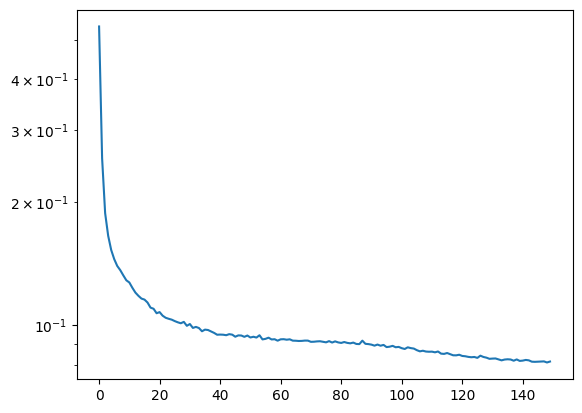

In [24]:
idx=0
plt.semilogy(results[idx]["train_losses"])

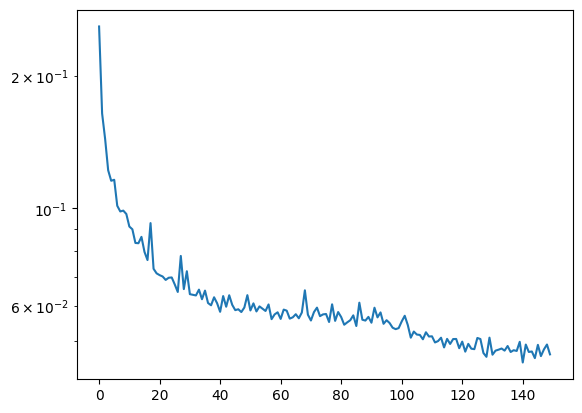

In [25]:
plt.semilogy(results[idx]["val_losses"])

In [26]:
ub_pred = results[idx]["ub_pred"]
lb_pred = results[idx]["lb_pred"]

In [27]:
lb_pred.shape, ub_pred.shape

((200, 51, 51), (200, 51, 51))

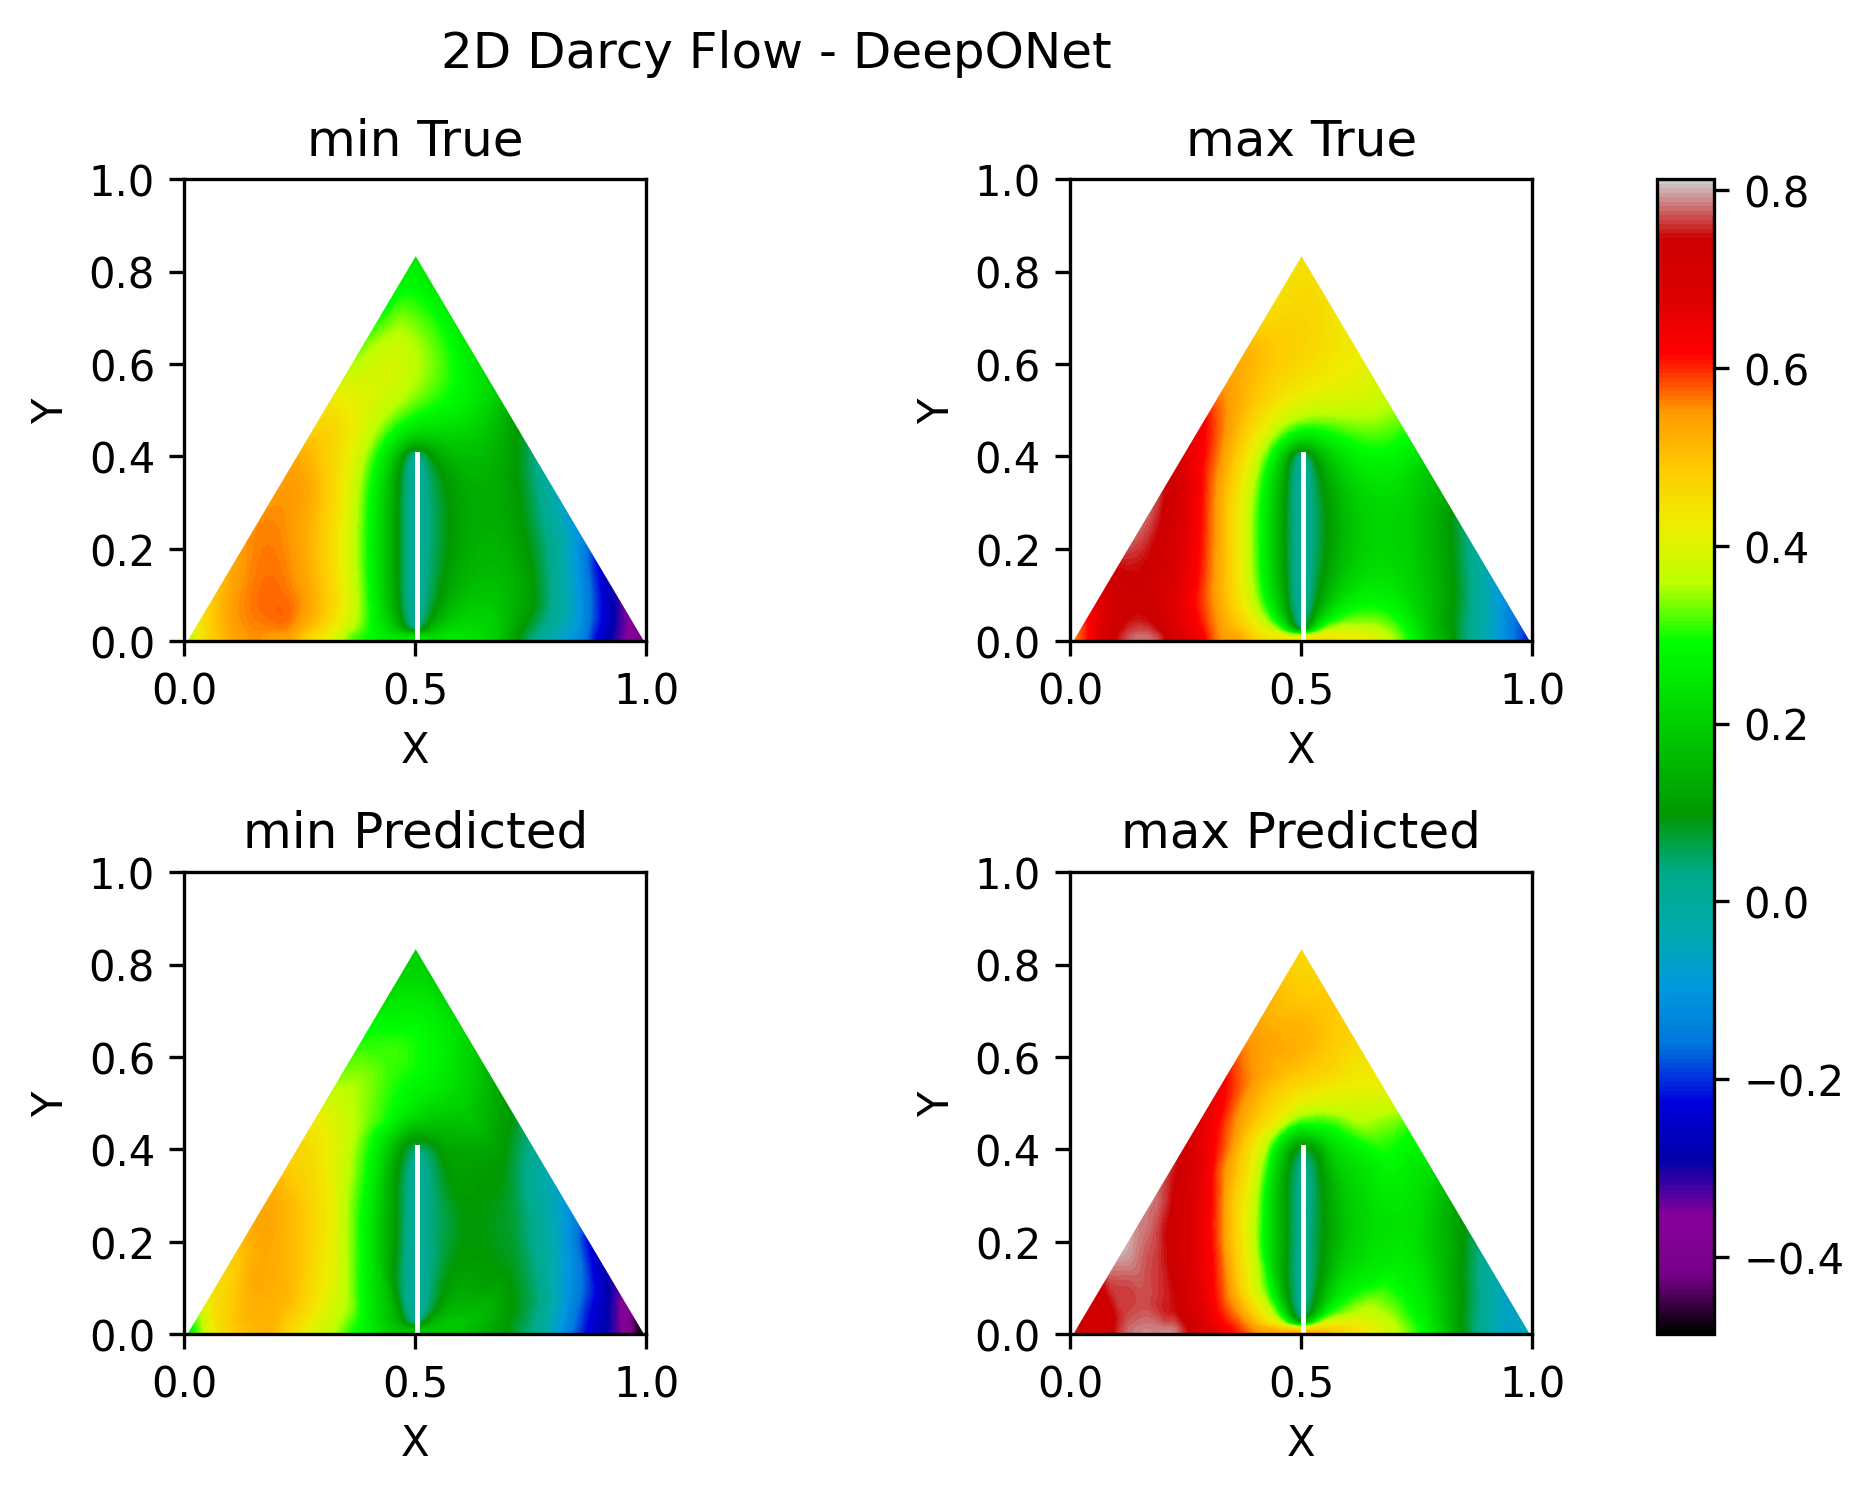

RMSE up = 0.0696
RMSE down = 0.0678


In [28]:
idx=0
ntest = 200

g_test = results[idx]["g_test"]
l_pred = lb_pred.reshape((ntest,51**2))
u_pred = ub_pred.reshape((ntest,51**2))

colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

# --- Parameters ---
s_disp = 1
xmax, ymax = s_disp, s_disp - 8/51
value = 17
vmax = np.max(ub_pred[value, ...])
vmin = np.min(lb_pred[value, ...])

# --- Helper function for plotting ---
def plot_field(ax, field, title, vmin, vmax):
    im = ax.imshow(
        field.reshape((51, 51)),
        origin='lower',
        extent=[0, 1, 0, 1],
        interpolation='Gaussian',
        cmap='nipy_spectral',
        vmin=vmin, vmax=vmax
    )
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # White triangular masks
    xf = np.array([0., xmax/2])
    ax.fill_between(xf, xf*(ymax/(xmax/2)), ymax, color='white')
    xf = np.array([xmax/2, xmax])
    ax.fill_between(xf, (xf-xmax)*(ymax/((xmax/2)-xmax)), ymax, color='white')
    ax.fill_between([0, xmax], ymax, s_disp, color='white')

    # Rectangle mask
    ax.add_patch(Rectangle((0.5, 0), 0.01, 0.41, facecolor='white'))

    return im

# --- Figure ---
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 5), dpi=300)
fig.suptitle('2D Darcy Flow - DeepONet')

fig.subplots_adjust(wspace=-0.2, hspace=0.5, right=0.88)

# True fields
im = plot_field(ax[0, 0], g_test[value, :, :, :, 0], "min True", vmin, vmax)
plot_field(ax[0, 1], g_test[value, :, :, :, 1], "max True", vmin, vmax)

# Predicted fields
plot_field(ax[1, 0], l_pred[value, :], "min Predicted", vmin, vmax)
plot_field(ax[1, 1], u_pred[value, :], "max Predicted", vmin, vmax)

# Shared colorbar
fig.colorbar(im, ax=ax.ravel().tolist())


plt.show()

# --- RMSE ---
rmse_up = np.sqrt(np.mean((g_test[...,0, 1] - ub_pred) ** 2))
print(f"RMSE up = {rmse_up:.4f}")

rmse_down = np.sqrt(np.mean((g_test[...,0, 0] - lb_pred) ** 2))
print(f"RMSE down = {rmse_down:.4f}")

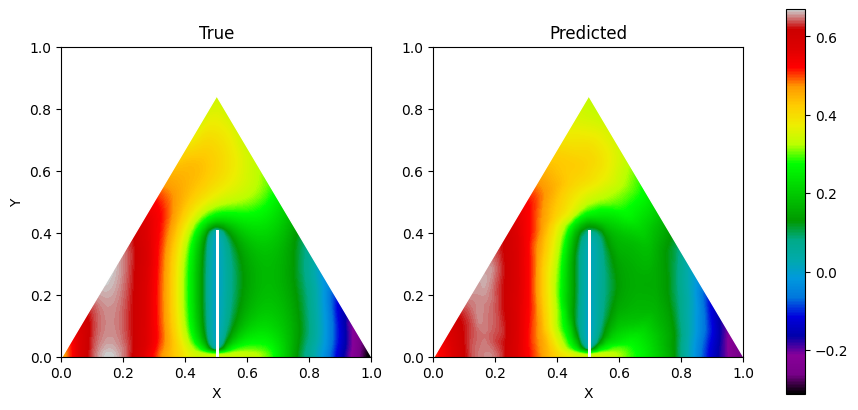

0.032885496


In [29]:
from matplotlib.patches import Rectangle

s_disp = 1
xmax = s_disp
ymax = s_disp-8/51
value = 17
g_test_mid = 0.5 * (g_test_int[...,0] + g_test_int[...,1])
preds = (l_pred + u_pred)/2
vmax = np.max(g_test_mid[value,:,:])
vmin = np.min(g_test_mid[value,:,:])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
# Interpolated LF
im = ax[0].imshow(g_test_mid[value,:,:].reshape((51,51)), origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral',
                  vmin=vmin, vmax=vmax
                  )
ax[0].set_title('True')

xf1 = np.array([0., xmax/2])
yf1 = xf1*(ymax/(xmax/2))
ax[0].fill_between(xf1, yf1, ymax, color = [1, 1, 1])
xf1 = np.array([xmax/2, xmax])
yf1 = (xf1-xmax)*(ymax/((xmax/2)-xmax))
ax[0].fill_between(xf1, yf1, ymax, color = [1, 1, 1])
xf1 = np.array([0, xmax])
ax[0].fill_between(xf1, ymax, s_disp, color = [1, 1, 1])
ax[0].add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")

# HF
im = ax[1].imshow(preds[value,:].reshape((51,51)), origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral',
                  vmin=vmin, vmax=vmax
                  )
ax[1].set_title('Predicted')

xf2 = np.array([0., xmax/2])
yf2 = xf2*(ymax/(xmax/2))
ax[1].fill_between(xf2, yf2, ymax, color = [1, 1, 1])
xf2 = np.array([xmax/2, xmax])
yf2 = (xf2-xmax)*(ymax/((xmax/2)-xmax))
ax[1].fill_between(xf2, yf2, ymax, color = [1, 1, 1])
xf2 = np.array([0, xmax])
ax[1].fill_between(xf2, ymax, s_disp, color = [1, 1, 1])
ax[1].add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))
ax[1].set_xlabel("X")
# ax[1].set_ylabel("Y")

fig.colorbar(im, ax=ax.ravel().tolist())

# rmse = np.sqrt(np.mean((g_test - preds)**2))

plt.show()

# print(f"RMSE overall = {rmse}")
print(np.sqrt(np.mean((g_test_mid[...,0] - preds.reshape(200,51,51))**2)))


In [30]:
g_test.shape

(200, 51, 51, 1, 2)

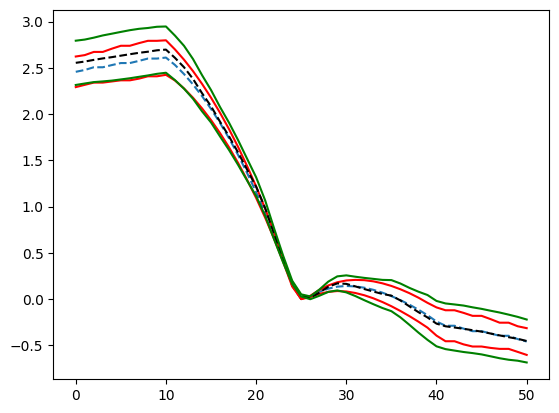

In [31]:
id = 0
y_coord = 17
plt.plot(g_test_mid[id,y_coord,:,:], '--')
plt.plot(g_test[id,y_coord,:,0, 0],'r')
plt.plot(g_test[id,y_coord,:,0, 1],'r')

plt.plot(preds.reshape(200,51,51)[id,y_coord,:], 'k--')
plt.plot(lb_pred[id,y_coord,:],'g')
plt.plot(ub_pred[id,y_coord,:],'g')